In [5]:
!pip install -U langchain-community ir_datasets faiss-cpu

  Using cached faiss_cpu-1.10.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (4.4 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 59.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 27.8 MB/s eta 0:00:00
  Attempting uninstall: async-timeout
    Found existing installation: async-timeout 5.0.1
    Uninstalling async-timeout-5.0.1:
      Successfully uninstalled async-timeout-5.0.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.3
    Uninstalling langchain-te

In [11]:
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.2 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 61.9 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
!pip install "rerankers[all]"

  Using cached litellm-1.63.12-py3-none-any.whl.metadata (36 kB)
  Using cached FlashRank-0.2.10-py3-none-any.whl.metadata (14 kB)
  Using cached flash_attn-2.7.4.post1.tar.gz (6.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached nmslib_metabrainz-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (956 bytes)
  Using cached rank_llm-0.21.0-py3-none-any.whl.metadata (28 kB)
  Using cached openai-1.68.0-py3-none-any.whl.metadata (25 kB)
  Using cached pyserini-0.44.0.tar.gz (195.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached fschat-0.2.36-py3-none-any.whl.metadata (20 kB)
  Using cached fastapi-0.115.11-py3-none-any.whl.metadata (27 kB)
  Using cached markdown2-2.5.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached nh3-0.2.21-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.meta

In [8]:
!pip install "rerankers[flashrank]"

  Using cached FlashRank-0.2.10-py3-none-any.whl.metadata (14 kB)
Using cached FlashRank-0.2.10-py3-none-any.whl (14 kB)


In [9]:
!pip install deep_translator ranx huggingface_hub

In [12]:
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
import faiss
import torch
from langchain.text_splitter import CharacterTextSplitter
import spacy
import pandas as pd
import numpy as np
import concurrent.futures
import pickle
from transformers import pipeline
from scipy.stats import skew
from langchain_text_splitters import TokenTextSplitter
from rerankers import Reranker
from deep_translator import GoogleTranslator
from collections import defaultdict
from ranx import Qrels, Run, evaluate
from transformers import logging
from huggingface_hub import login
login("")
logging.set_verbosity_error()

pd.set_option('display.max_colwidth', 100)
nlp = spacy.load("es_core_news_sm")
nlp = spacy.load("en_core_web_sm")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


In [20]:
model = SentenceTransformer("nomic-ai/nomic-embed-text-v2-moe", trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

config.json:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

configuration_hf_nomic_bert.py:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

modeling_hf_nomic_bert.py:   0%|          | 0.00/103k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [21]:
import ir_datasets
dataset = ir_datasets.load("codec/history")

In [4]:
needed_docs_ids = set()
for qrel in dataset.qrels_iter():
    needed_docs_ids.add(qrel.doc_id)
len(needed_docs_ids)

1884

In [5]:
history_docs = []
for doc in dataset.docs_iter():
    if doc.doc_id in needed_docs_ids:
        history_docs.append(doc)
len(history_docs)

1884

In [ ]:
with open("translated-docs-codec-history.pkl", "wb") as f:
    pickle.dump(history_docs, f)

In [6]:
with open("docs-codec-history.pkl", "rb") as f:
    history_docs = pickle.load(f)

#### Traduccion

In [22]:
class TranslatedCodecDoc:
    def __init__(self, doc, translated_text: str) -> None:
        self.doc_id = doc.doc_id
        self.text = translated_text
        self.title = doc.title
        self.count = doc.count
        self.index = doc.index
        self.url = doc.url

    @classmethod
    def from_codec_doc(cls, doc, text_translated: str) -> "TranslatedCodecDoc":
        return cls(doc, text_translated)

In [23]:
from deep_translator import GoogleTranslator
translator = GoogleTranslator(source='en', target='es')

In [18]:
d1 = history_docs[0]
nt = translator.translate(d1.text)
tcd = TranslatedCodecDoc.from_codec_doc(d1, nt)

In [ ]:
translated_history_docs: list[TranslatedCodecDoc] = []
for i, doc in enumerate(history_docs):
    try:
        doc_spacy = nlp(doc.text)
        new_text = ""
        current_sentences = ""
        for sent in doc_spacy.sents:
            if len(current_sentences) + len(sent.text) > 4500:
                translated_sentences = translator.translate(current_sentences)
                current_sentences = sent.text + " "
                new_text += translated_sentences + " "
            else:
                current_sentences += sent.text + " "

        translated_sentences = translator.translate(current_sentences)
        new_text += translated_sentences + " "
        current_sentences = ""

        translated_history_docs.append(TranslatedCodecDoc.from_codec_doc(doc, new_text))
        print(f"{i+1}/{len(history_docs)}: {doc.doc_id} translated")
    except Exception as e:
        print(f"Error translating doc-{i}/{doc.doc_id}: {e}")

In [24]:
class CodecHistoryStore:
    def __init__(self, docs: list[TranslatedCodecDoc]) -> None:
        self.docs = docs
        self.chunks = []
        self.chunks_ids = []
        self.embeddings = None

        self.__create_chunks()

    def __create_chunks(self):
        text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=50)
        for i, doc in enumerate(self.docs):
            new_chunks = text_splitter.split_text(doc.text)
            self.chunks.extend(new_chunks)
            self.chunks_ids.extend([i] * len(new_chunks))
    
    def doc_from_chunk_id(self, chunk_id: int) -> TranslatedCodecDoc:
        return self.docs[self.chunks_ids[chunk_id]]

    def chunk_from_id(self, chunk_id: int) -> str:
        return self.chunks[chunk_id]

    def generate_embeddings(self):
        model = SentenceTransformer("nomic-ai/nomic-embed-text-v2-moe", trust_remote_code=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        self.embeddings = model.encode(self.chunks, convert_to_tensor=True, prompt_name="passage")

In [25]:
# store = CodecHistoryStore(history_docs)
# len(store.chunks), len(store.chunks_ids)

with open("/kaggle/input/store-codec-history-translated/store-with-embeddings-translated-docs-codec-history.pkl", "rb") as f:
    store = pickle.load(f)
store.embeddings.shape

torch.Size([12707, 768])

In [26]:
embeddings_np = store.embeddings.cpu().numpy()
dimension = embeddings_np.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings_np)

In [14]:
faiss.write_index(index, "faiss-index-translated-docs-codec-history.bin")

In [27]:
import os
import torch
from transformers import pipeline
from huggingface_hub import InferenceClient

local_pipe = None
client_inference = None

# Save a cache of reformulated queries to avoid different results because of different queries
cache: dict[str, str] = {}

def __init_inference_client():
    global client_inference
    if client_inference is None:
        client_inference = InferenceClient(
            provider="sambanova", api_key=os.getenv("HF_TOKEN")
        )


def __init_pipe():
    global local_pipe
    if local_pipe is None:
        model_id = "meta-llama/Llama-3.2-1B-Instruct"
        local_pipe = pipeline(
            "text-generation",
            model=model_id,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )


def __rewrite_local(q: str, messages: str) -> str:
    __init_pipe()
    global local_pipe

    outputs = local_pipe(
        messages,
        max_new_tokens=256,
    )

    return outputs[0]["generated_text"][-1]["content"]


def __rewrite_inference(q: str, messages: str) -> str:
    __init_inference_client()
    global client_inference

    completion = client_inference.chat.completions.create(
        model="meta-llama/Llama-3.2-1B-Instruct",
        messages=messages,
        max_tokens=256,
    )

    return completion.choices[0].message.content


def rewrite(q: str, use_local_model: bool = False) -> str:
    messages = [
        {
            "role": "system",
            "content": "Eres un experto en historia latinoamericana. Tu tarea es tomar consultas relacionadas con la historia de América Latina y reformularlas para hacerlas más precisas, claras y detalladas. Deberías asegurarte de que la nueva consulta sea más específica, completa y comprensible. Responde solo con la consulta reformulada, sin agregar respuestas completas ni contenido adicional. No uses listas, títulos ni formato Markdown.",
        },
        {"role": "user", "content": q},
    ]
    if q in cache:
        return cache[q]

    cache[q] = __rewrite_local(q, messages) if use_local_model else __rewrite_inference(q, messages)
    return cache[q]

### Cargar qrels
Como en el dataset hay etiquetas de relevancia del 0 al 3, las que son mayores o iguales a 1 son marcadas como relevantes.

In [28]:
qrels = Qrels.from_ir_datasets("codec/history")
qrels_dict: dict = qrels.to_dict()

for key in qrels_dict.keys():
    for doc_id in qrels_dict[key]:
        if qrels_dict[key][doc_id] > 0:
            qrels_dict[key][doc_id] = 1

qrels = Qrels.from_dict(qrels_dict)
len(qrels)

[INFO] [starting] https://raw.githubusercontent.com/grill-lab/CODEC/main/topics/topics.json
[INFO] [finished] https://raw.githubusercontent.com/grill-lab/CODEC/main/topics/topics.json: [00:00] [47.2kB] [40.0MB/s]
[INFO] [starting] https://raw.githubusercontent.com/grill-lab/CODEC/main/raw_judgments/raw_document_judgments.txt
[INFO] [finished] https://raw.githubusercontent.com/grill-lab/CODEC/main/raw_judgments/raw_document_judgments.txt: [00:00] [307kB] [15.5MB/s]


14

In [29]:
def rerank2(ranker, query: str, initial: list[int], top_k=10) -> list[int]:
    already_in = set()
    relevant_chunks: list[tuple[str, str]] = []
    for i in initial:
        doc = store.doc_from_chunk_id(i)
        if doc.doc_id in already_in:
            continue

        already_in.add(doc.doc_id)
        relevant_chunks.append((store.chunk_from_id(i), doc.doc_id))
        if len(relevant_chunks) == top_k:
            break
    
    results = ranker.rank(
        query=query, 
        docs=[r[0] for r in relevant_chunks], 
        doc_ids=[r[1] for r in relevant_chunks],
    )
    
    return {r.document.doc_id: 1 for r in results}

In [30]:
def clean_query(query: str) -> str:
    query = query.replace('"', '').replace("'", '')
    query = query.replace("\n", " ").replace("\r", " ")
    query = query.replace("*", "").replace("-", "").replace("~", "")
    query = query.replace("  ", " ").strip()

    doc = nlp(query)
    sentences = [sent.text.strip() for sent in doc.sents]
    return " ".join([sent for sent in sentences if len(sent) > 0 and sent[-1] == '.']).lower()

def search_testing(query: str, top_k: int = 10) -> None:
    query_embedding = model.encode([clean_query(query)], convert_to_tensor=True, prompt_name="query", show_progress_bar=False).cpu().numpy()
    _, indices = index.search(query_embedding, k=top_k*4)

    already_in = set()
    results = {}
    for i in indices[0]:
        doc = store.doc_from_chunk_id(i)
        if doc.doc_id in already_in:
            continue

        already_in.add(doc.doc_id)
        results[doc.doc_id] = 1
        if len(results) == top_k:
            break
    return results

def search_rr_testing(ranker, query: str, top_k: int = 10) -> None:
    query_embedding = model.encode([clean_query(query)], convert_to_tensor=True, prompt_name="query", show_progress_bar=False).cpu().numpy()
    _, indices = index.search(query_embedding, k=top_k*4)
    return rerank2(ranker, query, indices[0], top_k=top_k)

In [31]:
# the queries must be in spanish
translator = GoogleTranslator(source='en', target='es')

In [42]:
def test(qrels, top_ks: list[int], metrics: list[str] = ["mrr", "ndcg", "recall", "precision", "map", "hit_rate"], use_rewriter: bool = True, search_function = search_testing, title_info: str = "SIN RERANK"):
    general_results = {}
    translated_queries = {}
    for query in dataset.queries_iter():
        translated_queries[query.query_id] = translator.translate(query.query)

    for top_k in top_ks:
        run_dict = {}
        for query in dataset.queries_iter():
            used_query = rewrite(
                translated_queries[query.query_id],
                use_local_model=True
            ) if use_rewriter else translated_queries[query.query_id]

            run_dict[query.query_id] = search_function(used_query, top_k=top_k)
    
        run = Run(run_dict)
        results = evaluate(qrels, run, metrics=metrics)
        general_results[top_k] = results
        title = f"=========TOP {top_k} {title_info}========="
        print(f"{title}\n{results}\n{len(title) * '='}")
    return title_info, general_results

In [43]:
def test_reranker(qrels, top_ks: list[int], reranker, reranker_name: str, metrics: list[str] = ["mrr", "ndcg", "recall", "precision", "map", "hit_rate"], use_rewriter: bool = True):
    return test(
        qrels,
        top_ks, 
        metrics=metrics,
        use_rewriter=use_rewriter,
        search_function=lambda query, **kw: search_rr_testing(reranker, query, **kw),
        title_info=f"CON REFORMULADOR Y RERANKER {reranker_name}"
    )

In [44]:
# Tests Ks
ks = [5, 10, 20]
all_results = {}

In [45]:
title_info, r = test(qrels, ks, use_rewriter=False, title_info="SIN RERANK Y SIN REFORMULADOR")
all_results[title_info] = r

=========TOP 5 SIN RERANK Y SIN REFORMULADOR=========
{'mrr': 0.08571428571428572, 'ndcg': 0.010814227667575367, 'recall': 0.004368279569892474, 'precision': 0.08571428571428572, 'map': 0.0031778033794162826, 'hit_rate': 0.14285714285714285}
=========TOP 10 SIN RERANK Y SIN REFORMULADOR=========
{'mrr': 0.09464285714285714, 'ndcg': 0.015529512570460003, 'recall': 0.007616147007876589, 'precision': 0.07142857142857142, 'map': 0.005031879487095685, 'hit_rate': 0.21428571428571427}
=========TOP 20 SIN RERANK Y SIN REFORMULADOR=========
{'mrr': 0.08511904761904762, 'ndcg': 0.018976824703512064, 'recall': 0.013130727582728357, 'precision': 0.06071428571428572, 'map': 0.004541157781547764, 'hit_rate': 0.35714285714285715}


In [46]:
title_info, r = test(qrels, ks, use_rewriter=True, title_info="CON REFORMULADOR Y SIN RERANK")
all_results[title_info] = r

=========TOP 5 CON REFORMULADOR Y SIN RERANK=========
{'mrr': 0.9285714285714286, 'ndcg': 0.15896233339599827, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.06008797156957605, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y SIN RERANK=========
{'mrr': 0.9285714285714286, 'ndcg': 0.2276549609654111, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.10614802459809036, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y SIN RERANK=========
{'mrr': 0.8095238095238095, 'ndcg': 0.3175140763358238, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.1800019964980808, 'hit_rate': 1.0}


In [47]:
ranker = Reranker('ms-marco-MultiBERT-L-12', lang='es', model_type='flashrank')
title_info, r = test_reranker(qrels, ks, ranker, 'ms-marco-MultiBERT-L-12')
all_results[title_info] = r

Loading FlashRankRanker model ms-marco-MultiBERT-L-12 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MultiBERT-L-12...
=========TOP 5 CON REFORMULADOR Y RERANKER ms-marco-MultiBERT-L-12=========
{'mrr': 0.9285714285714286, 'ndcg': 0.15800304071116736, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.059503958950988964, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER ms-marco-MultiBERT-L-12=========
{'mrr': 0.8452380952380952, 'ndcg': 0.21502385322469378, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.09906326489097585, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER ms-marco-MultiBERT-L-12=========
{'mrr': 0.815018315018315, 'ndcg': 0.3185813622468962, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.17819449246174868, 'hit_rate': 1.0}


In [48]:
rerank_model_name = "cross-encoder"
ranker = Reranker(rerank_model_name, lang='es')
title_info, r = test_reranker(qrels, ks, ranker, rerank_model_name)
all_results[title_info] = r

Loading default cross-encoder model for language es
Default Model: corrius/cross-encoder-mmarco-mMiniLMv2-L12-H384-v1
Loading TransformerRanker model corrius/cross-encoder-mmarco-mMiniLMv2-L12-H384-v1 (this message can be suppressed by setting verbose=0)
No device set
Using device cuda
No dtype set
Using dtype torch.float32


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

Loaded model corrius/cross-encoder-mmarco-mMiniLMv2-L12-H384-v1
Using device cuda.
Using dtype torch.float32.


tokenizer_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

=========TOP 5 CON REFORMULADOR Y RERANKER cross-encoder=========
{'mrr': 0.875, 'ndcg': 0.15313309287470261, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.05724814185142186, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER cross-encoder=========
{'mrr': 0.7797619047619049, 'ndcg': 0.21150849053908177, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.09730285413715466, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER cross-encoder=========
{'mrr': 0.8071428571428572, 'ndcg': 0.3205465913556082, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.18235627602323282, 'hit_rate': 1.0}


In [49]:
rerank_model_name = "unicamp-dl/InRanker-base"
ranker = Reranker(rerank_model_name, model_type="t5", verbose=0)
title_info, r = test_reranker(qrels, ks, ranker, rerank_model_name)
all_results[title_info] = r

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

=========TOP 5 CON REFORMULADOR Y RERANKER unicamp-dl/InRanker-base=========
{'mrr': 0.8571428571428571, 'ndcg': 0.15467989846436334, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.05885331305433244, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER unicamp-dl/InRanker-base=========
{'mrr': 0.7857142857142857, 'ndcg': 0.2159423332695912, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.10051407746608407, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER unicamp-dl/InRanker-base=========
{'mrr': 0.784065934065934, 'ndcg': 0.3159199879188712, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.180254224419571, 'hit_rate': 1.0}


In [50]:
rerank_model_name = "hiiamsid/est5-base"
ranker = Reranker(rerank_model_name, model_type="t5", verbose=0)
title_info, r = test_reranker(qrels, ks, ranker, rerank_model_name)
all_results[title_info] = r

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/950M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/671k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


=========TOP 5 CON REFORMULADOR Y RERANKER hiiamsid/est5-base=========
{'mrr': 0.9285714285714286, 'ndcg': 0.15896233339599827, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.06008797156957605, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER hiiamsid/est5-base=========
{'mrr': 0.9285714285714286, 'ndcg': 0.2276549609654111, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.10614802459809036, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER hiiamsid/est5-base=========
{'mrr': 0.8095238095238095, 'ndcg': 0.3175140763358238, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.1800019964980808, 'hit_rate': 1.0}


In [51]:
rerank_model_name = "ms-marco-TinyBERT-L-2-v2"
ranker = Reranker(rerank_model_name, lang='es', model_type='flashrank')
title_info, r = test_reranker(qrels, ks, ranker, rerank_model_name)
all_results[title_info] = r

Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


ms-marco-TinyBERT-L-2-v2.zip: 100%|██████████| 3.26M/3.26M [00:00<00:00, 49.5MiB/s]


=========TOP 5 CON REFORMULADOR Y RERANKER ms-marco-TinyBERT-L-2-v2=========
{'mrr': 0.8928571428571429, 'ndcg': 0.15720572736067973, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.059524538991515816, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER ms-marco-TinyBERT-L-2-v2=========
{'mrr': 0.7738095238095238, 'ndcg': 0.21459241159698625, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.09971643328901682, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER ms-marco-TinyBERT-L-2-v2=========
{'mrr': 0.7970588235294117, 'ndcg': 0.3174999480624257, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.1803822266288848, 'hit_rate': 1.0}


In [52]:
rerank_model_name = "ms-marco-MiniLM-L-12-v2"
ranker = Reranker(rerank_model_name, lang='es', model_type='flashrank')
title_info, r = test_reranker(qrels, ks, ranker, rerank_model_name)
all_results[title_info] = r

Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...


ms-marco-MiniLM-L-12-v2.zip: 100%|██████████| 21.6M/21.6M [00:00<00:00, 94.4MiB/s]


=========TOP 5 CON REFORMULADOR Y RERANKER ms-marco-MiniLM-L-12-v2=========
{'mrr': 0.8928571428571429, 'ndcg': 0.15397222461830648, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.057197411331941346, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER ms-marco-MiniLM-L-12-v2=========
{'mrr': 0.9285714285714286, 'ndcg': 0.22106047511758914, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.09990767881973277, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER ms-marco-MiniLM-L-12-v2=========
{'mrr': 0.8293650793650793, 'ndcg': 0.32746481839300595, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.18962043114090849, 'hit_rate': 1.0}


In [53]:
rerank_model_name = "rank-T5-flan"
ranker = Reranker(rerank_model_name, lang='es', model_type='flashrank')
title_info, r = test_reranker(qrels, ks, ranker, rerank_model_name)
all_results[title_info] = r

Loading FlashRankRanker model rank-T5-flan (this message can be suppressed by setting verbose=0)
Loading model FlashRank model rank-T5-flan...


rank-T5-flan.zip: 100%|██████████| 73.7M/73.7M [00:00<00:00, 187MiB/s] 


=========TOP 5 CON REFORMULADOR Y RERANKER rank-T5-flan=========
{'mrr': 0.9285714285714286, 'ndcg': 0.16028287878613148, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.061148635196729036, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER rank-T5-flan=========
{'mrr': 0.8392857142857143, 'ndcg': 0.22101916513749015, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.10327821152318592, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER rank-T5-flan=========
{'mrr': 0.7739974937343358, 'ndcg': 0.3114934677646349, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.17337548591210705, 'hit_rate': 1.0}


In [54]:
rerank_model_name = "ms-marco-MultiBERT-L-12"
ranker = Reranker(rerank_model_name, lang='es', model_type='flashrank')
title_info, r = test_reranker(qrels, ks, ranker, rerank_model_name)
all_results[title_info] = r

Loading FlashRankRanker model ms-marco-MultiBERT-L-12 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MultiBERT-L-12...
=========TOP 5 CON REFORMULADOR Y RERANKER ms-marco-MultiBERT-L-12=========
{'mrr': 0.9285714285714286, 'ndcg': 0.15800304071116736, 'recall': 0.06265745439171845, 'precision': 0.8285714285714286, 'map': 0.059503958950988964, 'hit_rate': 0.9285714285714286}
=========TOP 10 CON REFORMULADOR Y RERANKER ms-marco-MultiBERT-L-12=========
{'mrr': 0.8452380952380952, 'ndcg': 0.21502385322469378, 'recall': 0.1136532645540951, 'precision': 0.7642857142857142, 'map': 0.09906326489097585, 'hit_rate': 0.9285714285714286}
=========TOP 20 CON REFORMULADOR Y RERANKER ms-marco-MultiBERT-L-12=========
{'mrr': 0.815018315018315, 'ndcg': 0.3185813622468962, 'recall': 0.21807666162498202, 'precision': 0.7285714285714284, 'map': 0.17819449246174868, 'hit_rate': 1.0}


In [55]:
all_results

{'SIN RERANK Y SIN REFORMULADOR': {5: {'mrr': 0.08571428571428572,
   'ndcg': 0.010814227667575367,
   'recall': 0.004368279569892474,
   'precision': 0.08571428571428572,
   'map': 0.0031778033794162826,
   'hit_rate': 0.14285714285714285},
  10: {'mrr': 0.09464285714285714,
   'ndcg': 0.015529512570460003,
   'recall': 0.007616147007876589,
   'precision': 0.07142857142857142,
   'map': 0.005031879487095685,
   'hit_rate': 0.21428571428571427},
  20: {'mrr': 0.08511904761904762,
   'ndcg': 0.018976824703512064,
   'recall': 0.013130727582728357,
   'precision': 0.06071428571428572,
   'map': 0.004541157781547764,
   'hit_rate': 0.35714285714285715}},
 'CON REFORMULADOR Y SIN RERANK': {5: {'mrr': 0.9285714285714286,
   'ndcg': 0.15896233339599827,
   'recall': 0.06265745439171845,
   'precision': 0.8285714285714286,
   'map': 0.06008797156957605,
   'hit_rate': 0.9285714285714286},
  10: {'mrr': 0.9285714285714286,
   'ndcg': 0.2276549609654111,
   'recall': 0.1136532645540951,
   'pr

# Graficos

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
all_results

<ipython-input-66-c18e78f4decb>:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


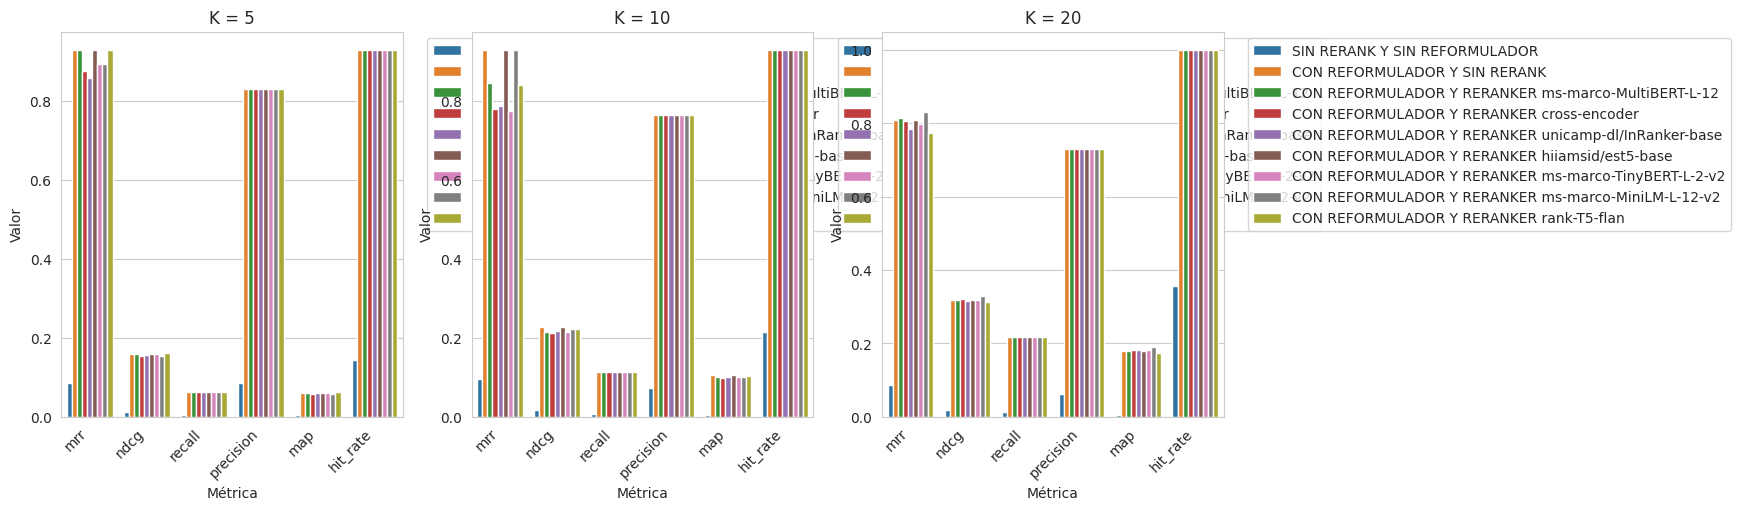

In [66]:
data = []
for method, k_values in all_results.items():
    for k, metrics in k_values.items():
        for metric, value in metrics.items():
            data.append([method, k, metric, value])
df = pd.DataFrame(data, columns=["Método", "K", "Métrica", "Valor"])

k_values = df["K"].unique()
n_rows = len(k_values) // 3 + (len(k_values) % 3 > 0)
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten()

sns.set_style("whitegrid")
for i, k in enumerate(k_values):
    ax = axes[i]
    subset = df[df["K"] == k]
    sns.barplot(data=subset, x="Métrica", y="Valor", hue="Método", ax=ax)
    ax.set_title(f"K = {k}")
    ax.set_xlabel("Métrica")
    ax.set_ylabel("Valor")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()